In [1]:
import numpy as np
import matplotlib.pyplot as plt
from vamos import (
    # Tuning utilities
    ParamSpace, Real, Int, Categorical,
    RandomSearchTuner, TuningTask, EvalContext, Instance,
    # Config space builders
    build_nsgaii_config_space, config_from_assignment,
    # Optimization
    optimize, OptimizeConfig, make_problem_selection,
)
from vamos.foundation.metrics import compute_hypervolume

plt.style.use("ggplot")
print("Tuning utilities loaded successfully!")

Tuning utilities loaded successfully!


## 1. Define a Custom Parameter Space

Create a search space with different parameter types:

In [2]:
# Define a richer parameter space for NSGA-II
custom_space = ParamSpace(params={
    "pop_size": Int("pop_size", 60, 150),
    "crossover_prob": Real("crossover_prob", 0.7, 0.95),
    "crossover_eta": Real("crossover_eta", 5.0, 30.0),
    "mutation_prob": Real("mutation_prob", 0.01, 0.2),
    "mutation_eta": Real("mutation_eta", 5.0, 30.0),
    "selection_pressure": Int("selection_pressure", 2, 4),
})

# Sample a few configurations to see what they look like
rng = np.random.default_rng(42)
for i in range(3):
    sample = custom_space.sample(rng)
    print(f"Sample {i+1}: {sample}")


Sample 1: {'pop_size': 68, 'crossover_prob': 0.8097196099380131, 'crossover_eta': 26.464947997784563, 'mutation_prob': 0.14249992552127916, 'mutation_eta': 7.354433697191238, 'selection_pressure': 4}
Sample 2: {'pop_size': 107, 'crossover_prob': 0.8902849254975882, 'crossover_eta': 24.651607631923845, 'mutation_prob': 0.034341590208353714, 'mutation_eta': 16.25964844738918, 'selection_pressure': 4}
Sample 3: {'pop_size': 105, 'crossover_prob': 0.9316912472121504, 'crossover_eta': 21.096628002016615, 'mutation_prob': 0.1663247065214577, 'mutation_eta': 16.085354970683277, 'selection_pressure': 3}


## 2. Simple Random Search Tuning

Use `RandomSearchTuner` to find good hyperparameters for NSGA-II on ZDT1:

In [3]:
# Create problem selection
selection = make_problem_selection("zdt1", n_var=10)
problem = selection.instantiate()

# Reference point for hypervolume (slightly worse than nadir)
ref_point = np.array([1.1, 1.1])

# Define evaluation function: run NSGA-II and return hypervolume
def evaluate_config(config: dict, ctx: EvalContext) -> float:
    """Evaluate a configuration and return hypervolume (higher = better)."""
    from vamos import NSGAIIConfig
    
    # Build algorithm config from sampled parameters
    algo_config = (
        NSGAIIConfig()
        .pop_size(int(config["pop_size"]))
        .offspring_size(int(config["pop_size"]))
        .crossover("sbx", prob=config["crossover_prob"], eta=config["crossover_eta"])
        .mutation("pm", prob=config["mutation_prob"], eta=config["mutation_eta"])
        .selection("tournament", pressure=int(config["selection_pressure"]))
        .survival("nsga2")
        .engine("numpy")
        .fixed()
    )
    
    # Run optimization with budget similar to comparison
    opt_config = OptimizeConfig(
        problem=problem,
        algorithm="nsgaii",
        algorithm_config=algo_config,
        termination=("n_eval", ctx.budget),
        seed=ctx.seed,
    )
    result = optimize(opt_config)
    
    # Compute hypervolume
    hv = compute_hypervolume(result.F, ref_point)
    return hv


In [4]:
# Create tuning task
# Use a higher budget per run to align with final comparison budget
# and multiple seeds to improve robustness.
task = TuningTask(
    name="nsgaii_zdt1_tuning",
    param_space=custom_space,
    instances=[Instance(name="zdt1", n_var=10)],
    seeds=[42, 123],  # Multiple seeds for robustness
    budget_per_run=1500,  # Larger budget to match comparison scale
    maximize=True,  # Maximize hypervolume
)

# Run random search with more trials
tuner = RandomSearchTuner(task=task, max_trials=25, seed=123)
best_config, history = tuner.run(evaluate_config, verbose=True)

print("\nBest configuration found:")
for k, v in best_config.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")


[trial 0] max score=0.628711
[trial 1] max score=0.643945
[trial 2] max score=0.572806
[trial 3] max score=0.675942
[trial 4] max score=0.386269
[trial 5] max score=0.574743
[trial 6] max score=0.599947
[trial 7] max score=0.495197
[trial 8] max score=0.526475
[trial 9] max score=0.456769
[trial 10] max score=0.353627
[trial 11] max score=0.619975
[trial 12] max score=0.679094
[trial 13] max score=0.572677
[trial 14] max score=0.493401
[trial 15] max score=0.423320
[trial 16] max score=0.550397
[trial 17] max score=0.724093
[trial 18] max score=0.596874
[trial 19] max score=0.518268
[trial 20] max score=0.505348
[trial 21] max score=0.573655
[trial 22] max score=0.432354
[trial 23] max score=0.458479
[trial 24] max score=0.640503
[tuner] Best score=0.724093

Best configuration found:
  pop_size: 87
  crossover_prob: 0.9376
  crossover_eta: 12.9719
  mutation_prob: 0.1806
  mutation_eta: 13.4382
  selection_pressure: 4


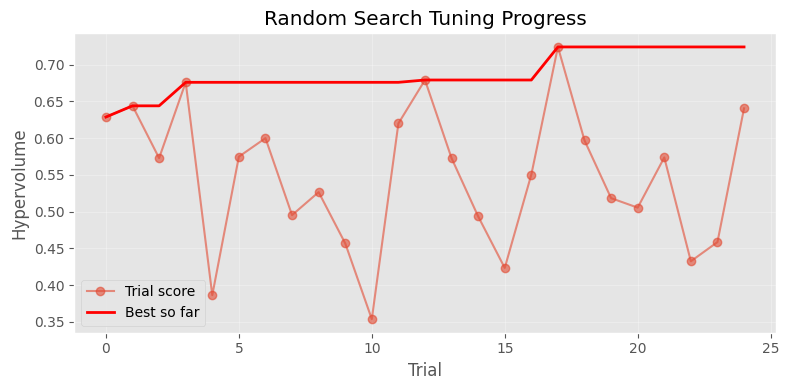

In [5]:
# Visualize tuning progress
scores = [trial.score for trial in history]
best_so_far = np.maximum.accumulate(scores)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(scores, 'o-', alpha=0.6, label="Trial score")
ax.plot(best_so_far, 'r-', linewidth=2, label="Best so far")
ax.set_xlabel("Trial")
ax.set_ylabel("Hypervolume")
ax.set_title("Random Search Tuning Progress")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Using Built-in Config Spaces

VAMOS provides pre-built configuration spaces for all algorithms:

In [6]:
# Get the built-in NSGA-II config space
nsgaii_space = build_nsgaii_config_space()

print(f"Algorithm: {nsgaii_space.algorithm_name}")
print(f"\nParameters ({len(nsgaii_space.params)}):")
for param in nsgaii_space.params:
    print(f"  - {param.name}: {type(param).__name__}")

Algorithm: nsgaii

Parameters (10):
  - pop_size: Int
  - offspring_size: Int
  - engine: Categorical
  - crossover: Categorical
  - crossover_prob: Real
  - mutation: Categorical
  - mutation_prob: Real
  - mutation_eta: Real
  - selection: Categorical
  - selection_pressure: Int


In [7]:
# Sample from the built-in space
rng = np.random.default_rng(42)
sampled = nsgaii_space.sample(rng)

print("Sampled configuration:")
for k, v in sampled.items():
    print(f"  {k}: {v}")

Sampled configuration:
  pop_size: 119
  offspring_size: 55
  engine: numba
  crossover: blx_alpha
  crossover_prob: 0.8440788101707773
  mutation: pm
  mutation_prob: 0.4880549523020104
  mutation_eta: 31.639889569662355
  selection: tournament
  selection_pressure: 2
  crossover_alpha: 0.6502450136938677


In [8]:
# Convert sampled assignment to a concrete config object
concrete_config = config_from_assignment("nsgaii", sampled)

print(f"Pop size: {concrete_config.pop_size}")
print(f"Crossover: {concrete_config.crossover}")
print(f"Mutation: {concrete_config.mutation}")

Pop size: 119
Crossover: ('blx_alpha', {'prob': 0.8440788101707773, 'alpha': 0.6502450136938677})
Mutation: ('pm', {'prob': 0.4880549523020104, 'eta': 31.639889569662355})


## 4. Multi-Instance Tuning

Tune across multiple problem instances for more robust configurations:

In [9]:
# Define multiple instances
instances = [
    Instance(name="zdt1_small", n_var=10),
    Instance(name="zdt1_medium", n_var=20),
]

# Evaluation function that handles different instances
def evaluate_multi_instance(config: dict, ctx: EvalContext) -> float:
    from vamos import NSGAIIConfig
    
    # Create problem based on instance
    prob = make_problem_selection("zdt1", n_var=ctx.instance.n_var).instantiate()
    
    algo_config = (
        NSGAIIConfig()
        .pop_size(int(config["pop_size"]))
        .offspring_size(int(config["pop_size"]))
        .crossover("sbx", prob=config["crossover_prob"], eta=config["crossover_eta"])
        .mutation("pm", prob=config["mutation_prob"], eta=config["mutation_eta"])
        .selection("tournament", pressure=int(config["selection_pressure"]))
        .survival("nsga2")
        .engine("numpy")
        .fixed()
    )
    
    result = optimize(OptimizeConfig(
        problem=prob,
        algorithm="nsgaii",
        algorithm_config=algo_config,
        termination=("n_eval", ctx.budget),
        seed=ctx.seed,
    ))
    
    return compute_hypervolume(result.F, np.array([1.1, 1.1]))


In [10]:
# Multi-instance tuning task
multi_task = TuningTask(
    name="nsgaii_multi_instance",
    param_space=custom_space,
    instances=instances,
    seeds=[42, 123],  # Multiple seeds
    budget_per_run=300,
    maximize=True,
    aggregator=np.mean,  # Average HV across instances and seeds
)

print(f"Task: {multi_task.name}")
print(f"Instances: {len(multi_task.instances)}")
print(f"Seeds: {len(multi_task.seeds)}")
print(f"Evaluations per config: {len(multi_task.instances) * len(multi_task.seeds)}")

Task: nsgaii_multi_instance
Instances: 2
Seeds: 2
Evaluations per config: 4


In [11]:
# Run tuning (fewer trials since each trial is more expensive)
multi_tuner = RandomSearchTuner(task=multi_task, max_trials=10, seed=456)
best_multi, history_multi = multi_tuner.run(evaluate_multi_instance, verbose=True)

print("\nBest robust configuration:")
for k, v in best_multi.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")


[trial 0] max score=0.000000
[trial 1] max score=0.000000
[trial 2] max score=0.004450
[trial 3] max score=0.000999
[trial 4] max score=0.000000
[trial 5] max score=0.000000
[trial 6] max score=0.001748
[trial 7] max score=0.016949
[trial 8] max score=0.012053
[trial 9] max score=0.000000
[tuner] Best score=0.016949

Best robust configuration:
  pop_size: 84
  crossover_prob: 0.8778
  crossover_eta: 5.5792
  mutation_prob: 0.1921
  mutation_eta: 23.9592
  selection_pressure: 3


## 5. Validate the Tuned Configuration

Compare tuned vs default configuration on a fresh run:

In [12]:
from vamos import NSGAIIConfig

# Default configuration
default_cfg = (
    NSGAIIConfig()
    .pop_size(80)
    .offspring_size(80)
    .crossover("sbx", prob=0.9, eta=20)
    .mutation("pm", prob=0.1, eta=20)
    .selection("tournament", pressure=2)
    .survival("nsga2")
    .engine("numpy")
    .fixed()
)

# Tuned configuration (single-instance best)
tuned_cfg = (
    NSGAIIConfig()
    .pop_size(80)
    .offspring_size(80)
    .crossover("sbx", prob=best_config["crossover_prob"], eta=best_config["crossover_eta"])
    .mutation("pm", prob=best_config["mutation_prob"], eta=best_config["mutation_eta"])
    .selection("tournament", pressure=int(best_config["selection_pressure"]))
    .survival("nsga2")
    .engine("numpy")
    .fixed()
)

# Run both with same seed at higher budget to compare fairly
test_problem = make_problem_selection("zdt1", n_var=20).instantiate()
comparison_budget = 4000

result_default = optimize(OptimizeConfig(
    problem=test_problem, algorithm="nsgaii", algorithm_config=default_cfg,
    termination=("n_eval", comparison_budget), seed=999
))

result_tuned = optimize(OptimizeConfig(
    problem=test_problem, algorithm="nsgaii", algorithm_config=tuned_cfg,
    termination=("n_eval", comparison_budget), seed=999
))

hv_default = compute_hypervolume(result_default.F, ref_point)
hv_tuned = compute_hypervolume(result_tuned.F, ref_point)

print(f"Default config HV: {hv_default:.6f}")
print(f"Tuned config HV:   {hv_tuned:.6f}")
print(f"Improvement: {(hv_tuned - hv_default) / hv_default * 100:.2f}%")


Default config HV: 0.798494
Tuned config HV:   0.807507
Improvement: 1.13%


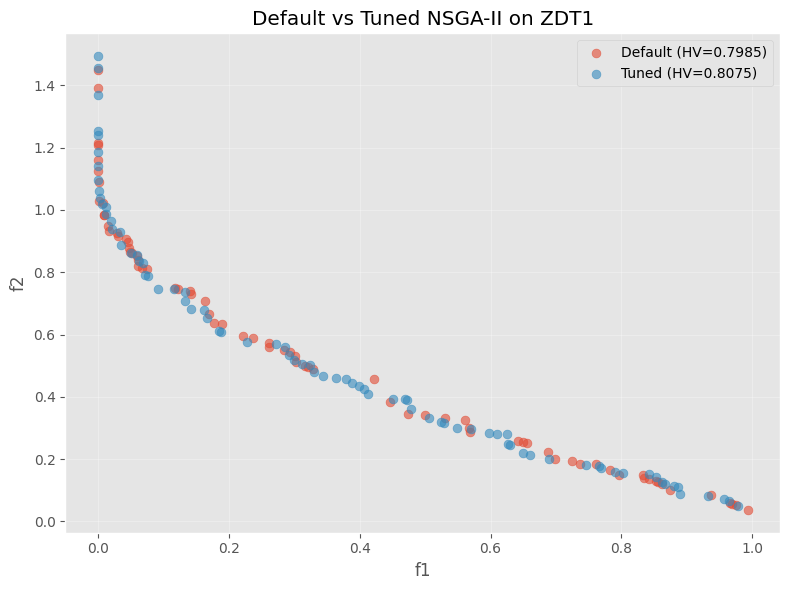

In [13]:
# Visual comparison
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(result_default.F[:, 0], result_default.F[:, 1], 
           s=40, alpha=0.6, label=f"Default (HV={hv_default:.4f})")
ax.scatter(result_tuned.F[:, 0], result_tuned.F[:, 1], 
           s=40, alpha=0.6, label=f"Tuned (HV={hv_tuned:.4f})")

ax.set_xlabel("f1")
ax.set_ylabel("f2")
ax.set_title("Default vs Tuned NSGA-II on ZDT1")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

VAMOS provides flexible hyperparameter tuning:

| Component | Purpose |
|-----------|----------|
| `ParamSpace` | Define search space with Real, Int, Categorical params |
| `TuningTask` | Specify instances, seeds, budget, aggregation |
| `RandomSearchTuner` | Simple random search |
| `RacingTuner` | Efficient irace-style elimination |
| `build_*_config_space()` | Pre-built spaces for each algorithm |
| `config_from_assignment()` | Convert samples to concrete configs |

**Tips:**
- Start with `RandomSearchTuner` for quick exploration
- Use `RacingTuner` for larger budgets (more efficient)
- Tune across multiple instances for robust configs
- Use multiple seeds to reduce noise